## Preparation

### Imports and authentication

In [ ]:
from google.colab import auth
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches
import cv2 as cv
import pandas as pd
import subprocess
import itertools
from tqdm import tqdm
import os
import numba as nb
import hashlib
import time
import subprocess
import re
plt.style.use("seaborn-v0_8-white")

from google.colab import drive
drive.mount('/content/gdrive')

auth.authenticate_user()

Mounted at /content/gdrive


## Stitching code

In [ ]:
AREA_THRESHOLD = 100
OVERLAP = 256
MAX_TILE_SIZE = 4096


id_base = np.array([MAX_TILE_SIZE, 1])


def remove_small_segments_inplace(watershed_img):
    ids, counts = np.unique(watershed_img, return_counts=True)
    watershed_img[np.isin(watershed_img, ids[counts < AREA_THRESHOLD])] = 0

def prepare_segment_ids(watershed_img1, watershed_img2):
    remove_small_segments_inplace(watershed_img1)
    remove_small_segments_inplace(watershed_img2)

    return watershed_img1, watershed_img2

@nb.njit(fastmath=True)
def get_intersection_coords(img, line_coord, axis):
    if axis == 0:
         line_strip = img[line_coord, :]
    elif axis == 1:
        line_strip = img[:, line_coord]
    segment_ids = np.unique(line_strip)
    segment_ids = segment_ids[segment_ids > 0]  # remove background segment ID if present
    intersection_coords = np.empty((0, 2), dtype=np.int64)
    for segment_id in segment_ids:
        if segment_id < 1:
            continue
        segment_coords = np.argwhere(img == segment_id)  # for production: maybe use cupy on Cuda GPU to speed up
        intersection_coords=np.vstack((intersection_coords, segment_coords))

    return intersection_coords

@nb.njit(fastmath=True)
def calc_coord_id(segment_coords):
    return np.sum(segment_coords * id_base, axis=1)

@nb.njit(fastmath=True)
def find_segments(segmentation):
    # Find unique segment IDs
    segment_ids = np.unique(segmentation)
    segment_ids = segment_ids[segment_ids > 1]  # Remove background segment ID if present

    # Initialize a dictionary to store segment representations
    segment_representations = nb.typed.Dict()
    segment_coords_dict = nb.typed.Dict()

    # Iterate over each segment ID

    for segment_id in segment_ids:
        # Find coordinates where segment ID occurs
        segment_coords = np.argwhere(segmentation == segment_id)
        #segment_coords_t = transform_coords(segment_coords, offset_y, offset_x)

        segment_representations[segment_id] = calc_coord_id(segment_coords)
        segment_coords_dict[segment_id] = segment_coords

    return segment_representations, segment_coords_dict

@nb.njit(fastmath=True)
def get_iou_and_uncertainty(
        seg1,
        seg2,
        uncertainty_map1,
        uncertainty_map2,
    ):
    # Find bounding boxes for segments in both images
    seg1_rep, seg1 = find_segments(seg1)
    seg2_rep, seg2 = find_segments(seg2)
    iou = iou_segments(seg1_rep, seg2_rep)
    uncertainty1 = get_uncertainty(seg1, uncertainty_map1)
    uncertainty2 = get_uncertainty(seg2, uncertainty_map2)

    return iou, uncertainty1, uncertainty2

@nb.njit(fastmath=True)
def iou_segments(seg1, seg2):
    # Initialize a matrix to store the IoUs
    iou = np.empty((len(seg1), len(seg2)), dtype=float)

    # Calculate IoU for each pair of segments
    # attention! relying on the order of dicts is only valid in >= Python 3.7
    for i, (seg1_id, seg1_element) in enumerate(seg1.items()):
        for j, (seg2_id, seg2_element) in enumerate(seg2.items()):
            intersection = np.intersect1d(
                seg1_element,
                seg2_element,
            )
            union = np.union1d(
                seg1_element,
                seg2_element,
            )
            iou[i, j] = len(intersection) / len(union)

    return iou

@nb.njit(fastmath=True)
def get_uncertainty(seg, uncertainty_img):
    uncertainty_dict = nb.typed.Dict()

    for i, (seg_id, seg_element) in enumerate(seg.items()):
        pixel = seg_element[0, :] # get arbitrary pixel from segment
        uncertainty_dict[seg_id] = uncertainty_img[pixel[0], pixel[1]]
    return uncertainty_dict

@nb.njit(fastmath=True)
def get_edge_segments(l_intersection_map, r_intersection_map, left_u, right_u, iou_threshold = 0.1):
    iou, left_uncertainty_dict, right_uncertainty_dict = get_iou_and_uncertainty(l_intersection_map, r_intersection_map, left_u, right_u)
    return non_max_suppresion(iou, left_uncertainty_dict, right_uncertainty_dict, iou_threshold)

@nb.njit(fastmath=True)
def non_max_suppresion(iou_matrix, uncertainty_dict1, uncertainty_dict2, iou_threshold):
    sorted_uncertainty_dict1 = dict(sorted(uncertainty_dict1.items(), key=lambda x: x[1]))
    sorted_uncertainty_dict2 = dict(sorted(uncertainty_dict2.items(), key=lambda x: x[1]))

    left_ids = np.array(list(uncertainty_dict1.keys()))
    right_ids = np.array(list(uncertainty_dict2.keys()))

    left_ids_sorted = list(sorted_uncertainty_dict1.keys())
    right_ids_sorted = list(sorted_uncertainty_dict2.keys())

    left_accept = set()
    right_accept = set()
    discard_left = set()
    discard_right = set()

    while len(left_ids_sorted) > 0 or len(right_ids_sorted) > 0:
        if len(left_ids_sorted) > 0 and len(right_ids_sorted) > 0:
            if sorted_uncertainty_dict1[left_ids_sorted[0]] < sorted_uncertainty_dict2[right_ids_sorted[0]]:
                left_wins = True
                seg_id = left_ids_sorted.pop(0)
            else:
                left_wins = False
                seg_id = right_ids_sorted.pop(0)
        elif len(left_ids_sorted) > 0:
            left_wins = True
            seg_id = left_ids_sorted.pop(0)
        else:
            left_wins = False
            seg_id = right_ids_sorted.pop(0)

        if left_wins:
            if seg_id in discard_left:
                continue
            seg_index = np.where(left_ids == seg_id)[0][0]
            left_accept.add(seg_id)
            discard_right.update(right_ids[np.argwhere(iou_matrix[seg_index, :] > iou_threshold).flatten()].flatten())
        elif seg_id in right_ids:
            if seg_id in discard_right:
                continue
            seg_index = np.where(right_ids == seg_id)[0][0]
            right_accept.add(seg_id)
            discard_left.update(left_ids[np.argwhere(iou_matrix[:, seg_index] > iou_threshold).flatten()].flatten())

    return left_accept, right_accept#, discard

@nb.njit(fastmath=True, parallel=True)
def set_by_isin(source, value_set, target):
    values = np.array(list(value_set))
    for i in nb.prange(source.shape[0]):
        for j in range(source.shape[1]):
            if source[i, j] in values:
                target[i, j] = source[i, j]
    return target

@nb.njit(fastmath=True)
def add_edge_segments_inplace(l_intersection_map, r_intersection_map, left_u, right_u, left, right, result1, result2):
    left_accept, right_accept = get_edge_segments(l_intersection_map, r_intersection_map, left_u, right_u)

    result1 = set_by_isin(left, np.array(list(left_accept)), result1)
    result2 = set_by_isin(right, np.array(list(right_accept)), result2)

    return result1, result2

def stitch_tiles(t1, t2, t1_iu, t2_iu, axis=0):
    if axis==0: # vertical
        if t1.shape[1] != t2.shape[1]:
            raise ValueError("Tiles need to have the same width!")

        overlap_slice1 = slice(-OVERLAP, None), slice(None)
        overlap_slice2 = slice(None, OVERLAP), slice(None)

    elif axis==1: # horizontal
        if t1.shape[0] != t2.shape[0]:
            raise ValueError("Tiles need to have the same height!")

        overlap_slice1 = slice(None), slice(-OVERLAP, None)
        overlap_slice2 = slice(None), slice(None, OVERLAP)
    else:
        raise NotImplementedError("Axis needs to be 0 (vertical) or 1 (horizontal)!")
    if t1.shape != t1_iu.shape or t2.shape != t2_iu.shape:
        raise ValueError("Segmentation maps and their respective uncertainty maps need to have the same shape.")

    t1, t2 = prepare_segment_ids(t1, t2)

    result1 = t1.copy()
    result2 = t2.copy()

    t1_overlap = t1[overlap_slice1]
    t2_overlap = t2[overlap_slice2]

    result1_overlap = result1[overlap_slice1]
    result2_overlap = result2[overlap_slice2]

    intersection_coords1 = get_intersection_coords(t1_overlap, OVERLAP//2, axis)
    intersection_coords2 = get_intersection_coords(t2_overlap, OVERLAP//2, axis)

    mask1 = np.zeros(t1_overlap.shape, dtype=bool)
    mask1[intersection_coords1[:, 0], intersection_coords1[:, 1]] = True
    mask2 = np.zeros(t2_overlap.shape, dtype=bool)
    mask2[intersection_coords2[:, 0], intersection_coords2[:, 1]] = True

    result1_overlap[mask1] = 0
    result2_overlap[mask2] = 0

    if axis==0:
        result1_overlap[-OVERLAP//2:, :] = 0
        result2_overlap[:OVERLAP//2, :] = 0
    elif axis==1:
        result1_overlap[:, -OVERLAP//2:] = 0
        result2_overlap[:, :OVERLAP//2] = 0

    intersection_map1 = t1_overlap.copy()
    intersection_map1[~mask1] = 0
    intersection_map2 = t2_overlap.copy()
    intersection_map2[~mask2] = 0

    add_edge_segments_inplace(
        intersection_map1,
        intersection_map2,
        t1_iu[overlap_slice1],
        t2_iu[overlap_slice2],
        t1_overlap,
        t2_overlap,
        result1_overlap,
        result2_overlap,
    )

    return result1, result2

def combine_tiles(t1, t2, axis=0):
    if axis==0: # vertical
        if t1.shape[1] != t2.shape[1]:
            raise ValueError("Tiles need to have the same width!")
        result = np.zeros((t1.shape[0] + t2.shape[0] - OVERLAP, t1.shape[1]), dtype=t1.dtype)
        result[t1.shape[0] - OVERLAP:, :] = t2
    elif axis==1: # horizontal
        if t1.shape[0] != t2.shape[0]:
            raise ValueError("Tiles need to have the same height!")
        result = np.zeros((t1.shape[0], t1.shape[1] + t2.shape[1] - OVERLAP), dtype=t1.dtype)
        result[:, t1.shape[1]-OVERLAP:] = t2

    result_roi = result[:t1.shape[0], :t1.shape[1]]
    result_roi[result_roi == 0] += t1[result_roi == 0]

    return result

def result_overlap(t1, t2, axis=0):
    if axis==0: # vertical
        if t1.shape[1] != t2.shape[1]:
            raise ValueError("Tiles need to have the same width!")
        result1 = np.zeros((t1.shape[0] + t2.shape[0] - OVERLAP, t1.shape[1]), dtype=bool)
        result2 = result1.copy()
        result1[t1.shape[0] - OVERLAP:, :] = (t2 > 0)
    elif axis==1: # horizontal
        if t1.shape[0] != t2.shape[0]:
            raise ValueError("Tiles need to have the same height!")
        result1 = np.zeros((t1.shape[0], t1.shape[1] + t2.shape[1] - OVERLAP), dtype=bool)
        result2 = result1.copy()

        result1[:, t1.shape[1]-OVERLAP:] = (t2 > 0)

    result2_roi = result2[:t1.shape[0], :t1.shape[1]]
    result2_roi[result2_roi == 0] = (t1[result2_roi == 0] > 0)

    return result1 & result2

In [ ]:
def repres(tile):
    return "{:02d}_{:05d}".format(tile.file_batch, tile.tile_id)

def get_edges(df):
    vertical_edges = []
    horizontal_edges = []
    for i, tile1 in df.iterrows():
        for j, tile2 in df.iterrows():
            if tile1.x == tile2.x and tile2.y-tile1.y == 1:
                horizontal_edges.append((repres(tile1), repres(tile2)))
            elif tile1.y == tile2.y and tile2.x-tile1.x == 1:
                vertical_edges.append((repres(tile1), repres(tile2)))
    return horizontal_edges, vertical_edges

In [ ]:
def list_files_in_bucket(bucket_path):
    try:
        # Run gsutil ls command to list files in the bucket
        command = f"gsutil ls -r gs://{bucket_path}"
        result = subprocess.run(command, shell=True, check=True, capture_output=True, text=True)

        # Split the output into lines to get individual file paths
        file_paths = result.stdout.strip().split("\n")
        return file_paths
    except subprocess.CalledProcessError as e:
        print(f"Error: {e}")
        return []

## Stitching pipeline

### Download and prepare metadata file

In [ ]:
roi = pd.read_csv("/content/gdrive/MyDrive/field_delineation/tiles_karnataka2.csv")

In [ ]:
!gsutil cp gs://india_field_delineation/metadata/india_airbus_metadata_all.csv /content/metadata.csv
metadata = pd.read_csv("/content/metadata.csv")
#metadata[["unknown0", "unknown1", "unknown2", "z", "x", "y"]] = metadata["DLTile_key"].str.split(":", expand=True)
#metadata[["z", "x", "y"]] = metadata[["z", "x", "y"]].astype(int)

Copying gs://india_field_delineation/metadata/india_airbus_metadata_all.csv...
\ [1 files][ 11.4 MiB/ 11.4 MiB]                                                
Operation completed over 1 objects/11.4 MiB.                                     


In [ ]:
meta_df = pd.merge(roi, metadata.loc[metadata.image_id==0], how="inner", left_on="key", right_on=["DLTile_key"])
meta_df.rename(columns={"batch_x": "stitching_batch", "batch_y": "file_batch"}, inplace=True)

In [ ]:
stitching_batches = sorted(meta_df.stitching_batch.unique())

In [ ]:
meta_df.file_batch.unique()

array([54, 55])

### Check which files are already there

In [ ]:
bucket_path = "india_field_delineation/predictions/watershed_instances_4096p_tileable/res"
bucket_files = list_files_in_bucket(bucket_path)

In [ ]:
bucket_files = [s for s in bucket_files if s.endswith(".npy")]
bucket_files = [f"{s[86:88]}/{s[95:100]}" for s in bucket_files]

In [ ]:
for batch_i in stitching_batches:
    meta_df_batch = meta_df.loc[meta_df["stitching_batch"] == batch_i]

    lost, found = [], []
    for i, row in meta_df_batch.loc[meta_df_batch["inner"]].iterrows():
        tile_id = row["tile_id"]
        file_batch = row["file_batch"]
        id = "{:02d}/{:05d}".format(file_batch, tile_id)
        if id in bucket_files:
            found.append(id)
        else:
            lost.append(id)
    print(f"Batch: {batch_i}\t found {len(found)}\t lost {len(lost)}")
    #if len(found) == 0:
    #    break



Batch: 0	 found 0	 lost 18
Batch: 1	 found 0	 lost 70
Batch: 2	 found 0	 lost 13
Batch: 3	 found 0	 lost 1
Batch: 4	 found 0	 lost 14
Batch: 5	 found 0	 lost 0


### Run the pipeline (including I/O) batch-wise

In [ ]:
os.system("mkdir /content/watershed")
os.system("mkdir /content/instance_uncertainty")
os.system("mkdir /content/res")

watershed_imgs = {}
instance_uncertainty_imgs = {}

In [ ]:
for batch_i in tqdm(stitching_batches):
    meta_df_batch = meta_df.loc[meta_df["stitching_batch"] == batch_i]


    for i, row in tqdm(meta_df_batch.iterrows()):
        tile_id = row["tile_id"]
        file_batch = row["file_batch"]
        key = "{:02d}_{:05d}".format(file_batch, tile_id)

        source = "gs://india_field_delineation/predictions/watershed_instances_4096px/india_{:02d}/india_{:05d}.npy".format(file_batch, tile_id)
        dest = f"/content/watershed/{key}.npy"
        if not os.path.exists(dest):
            os.system(
                f"gsutil cp {source} {dest}"
            )
        source = "gs://india_field_delineation/predictions/instance_uncertainty_4096px/india_{:02d}/india_{:05d}.png".format(file_batch, tile_id)
        dest = f"/content/instance_uncertainty/{key}.png"
        if not os.path.exists(dest):
            os.system(
                f"gsutil cp {source} {dest}"
            )

        img_path = f"/content/watershed/{key}.npy"
        if os.path.exists(img_path) and not key in watershed_imgs.keys():
                watershed_imgs[key] = np.load(img_path)
        img_path = f"/content/instance_uncertainty/{key}.png"
        if os.path.exists(img_path) and not key in instance_uncertainty_imgs.keys():
            instance_uncertainty_imgs[key] = cv.imread(img_path, cv.IMREAD_GRAYSCALE)

    h_edges, v_edges = get_edges(meta_df_batch)

    for v_edge in tqdm(v_edges):
        left, right = v_edge
        if not left in watershed_imgs.keys() or not left in instance_uncertainty_imgs.keys():
            print(f"{left} not found!")
            continue
        if not right in watershed_imgs.keys() or not right in instance_uncertainty_imgs.keys():
            print(f"{right} not found!")
            continue
        left_seg = watershed_imgs[left]
        right_seg = watershed_imgs[right]
        left_u = instance_uncertainty_imgs[left]
        right_u = instance_uncertainty_imgs[right]
        watershed_imgs[left], watershed_imgs[right] = stitch_tiles(left_seg, right_seg, left_u, right_u, axis=1)

    for h_edge in tqdm(h_edges):
        bottom, top = h_edge
        if not bottom in watershed_imgs.keys() or not bottom in instance_uncertainty_imgs.keys():
            print(f"{bottom} not found!")
            continue
        if not top in watershed_imgs.keys() or not top in instance_uncertainty_imgs.keys():
            print(f"{top} not found!")
            continue
        bottom_seg = watershed_imgs[bottom]
        top_seg = watershed_imgs[top]
        bottom_u = instance_uncertainty_imgs[bottom]
        top_u = instance_uncertainty_imgs[top]
        watershed_imgs[top], watershed_imgs[bottom] = stitch_tiles(top_seg, bottom_seg, top_u, bottom_u, axis=0)

    for i, row in tqdm(meta_df_batch.loc[meta_df_batch["inner"]].iterrows()):
        tile_id = row["tile_id"]
        file_batch = row["file_batch"]
        key = "{:02d}_{:05d}".format(file_batch, tile_id)
        if not key in watershed_imgs:
            continue

        dir = "/content/res/india_{:02d}/".format(file_batch)
        if not os.path.exists(dir):
            os.makedirs(dir)

        img_path = "/content/res/india_{:02d}/india_{:05d}.npy".format(file_batch, tile_id)
        np.save(img_path, watershed_imgs[key].astype(np.uint32), allow_pickle=False, fix_imports=False)

    dest = "gs://india_field_delineation/predictions/watershed_instances_4096p_tileable"
    source = "/content/res"
    os.system(
        f"gsutil cp -r {source} {dest}"
    )

    os.system("rm /content/watershed/*")
    os.system("rm /content/instance_uncertainty/*")
    os.system("rm -r /content/res/*")

    watershed_imgs = {}
    instance_uncertainty_imgs = {}

  0%|          | 0/6 [00:00<?, ?it/s]
0it [00:00, ?it/s]
1it [00:15, 15.43s/it]
2it [00:28, 14.25s/it]
3it [00:42, 14.16s/it]
4it [00:57, 14.19s/it]
5it [01:10, 13.97s/it]
6it [01:24, 13.95s/it]
7it [01:40, 14.61s/it]
8it [01:55, 14.81s/it]
9it [02:09, 14.59s/it]
10it [02:22, 14.02s/it]
11it [02:35, 13.70s/it]
12it [02:49, 13.65s/it]
13it [03:02, 13.57s/it]
14it [03:15, 13.31s/it]
15it [03:27, 13.01s/it]
16it [03:40, 12.84s/it]
17it [03:52, 12.76s/it]
18it [04:06, 13.07s/it]
19it [04:18, 12.88s/it]
20it [04:32, 13.05s/it]
21it [04:45, 13.04s/it]
22it [04:59, 13.37s/it]
23it [05:13, 13.46s/it]
24it [05:28, 14.00s/it]
25it [05:42, 13.88s/it]
26it [05:55, 13.66s/it]
27it [06:09, 13.69s/it]

100%|██████████| 22/22 [02:01<00:00,  5.53s/it]

100%|██████████| 19/19 [01:13<00:00,  3.87s/it]

0it [00:00, ?it/s]
3it [00:00, 20.70it/s]
6it [00:00, 19.93it/s]
8it [00:00, 18.82it/s]
10it [00:00, 17.37it/s]
12it [00:00, 12.78it/s]
14it [00:00, 12.78it/s]
16it [00:01, 13.10it/s]
18it [00:01, 13.68it/

  0%|          | 0/70 [00:00<?, ?it/s]
0it [00:00, ?it/s]
1it [00:20, 20.44s/it]
2it [00:36, 17.91s/it]
3it [00:51, 16.69s/it]
4it [01:07, 16.38s/it]
5it [01:21, 15.30s/it]
6it [01:35, 14.97s/it]
7it [01:50, 14.92s/it]
8it [02:05, 14.97s/it]
9it [02:19, 14.81s/it]
10it [02:34, 14.70s/it]
11it [02:48, 14.47s/it]
12it [03:02, 14.54s/it]
13it [03:17, 14.45s/it]
14it [03:31, 14.40s/it]
15it [03:45, 14.33s/it]
16it [04:00, 14.37s/it]
17it [04:13, 14.20s/it]
18it [04:30, 14.79s/it]
19it [04:44, 14.56s/it]
20it [04:58, 14.57s/it]
21it [05:12, 14.33s/it]
22it [05:25, 14.02s/it]
23it [05:39, 14.05s/it]
24it [05:53, 14.02s/it]
25it [06:08, 14.21s/it]
26it [06:20, 13.45s/it]
27it [06:34, 13.66s/it]
28it [06:48, 13.76s/it]
29it [07:02, 14.05s/it]
30it [07:16, 14.01s/it]
31it [07:30, 14.03s/it]
32it [07:45, 14.06s/it]
33it [07:59, 14.26s/it]
34it [08:14, 14.34s/it]
35it [08:28, 14.21s/it]
36it [08:41, 13.92s/it]
37it [08:56, 14.22s/it]
38it [09:11, 14.55s/it]
39it [09:24, 14.05s/it]
40it [09:37, 13

14_14800 not found!



 50%|█████     | 66/132 [04:42<04:40,  4.24s/it]

14_14829 not found!



 56%|█████▌    | 74/132 [05:11<03:55,  4.06s/it]

14_14858 not found!



 62%|██████▏   | 82/132 [05:38<03:01,  3.63s/it]

14_14887 not found!



 68%|██████▊   | 90/132 [06:04<02:30,  3.57s/it]

14_14916 not found!



 74%|███████▍  | 98/132 [06:30<01:56,  3.43s/it]

14_14945 not found!



 80%|████████  | 106/132 [06:55<01:28,  3.42s/it]

14_14974 not found!



100%|██████████| 132/132 [08:30<00:00,  3.87s/it]

 32%|███▏      | 42/132 [02:18<04:01,  2.69s/it]

14_14800 not found!
14_14800 not found!
14_14829 not found!
14_14858 not found!
14_14887 not found!
14_14916 not found!
14_14945 not found!
14_14974 not found!



100%|██████████| 132/132 [06:03<00:00,  2.75s/it]

0it [00:00, ?it/s]
1it [00:00,  9.16it/s]
3it [00:00,  8.98it/s]
4it [00:00,  8.66it/s]
5it [00:00,  8.70it/s]
6it [00:00,  8.36it/s]
7it [00:00,  8.11it/s]
8it [00:00,  7.63it/s]
9it [00:01,  7.10it/s]
10it [00:01,  6.37it/s]
11it [00:01,  6.32it/s]
12it [00:01,  6.30it/s]
13it [00:01,  6.52it/s]
14it [00:01,  6.55it/s]
15it [00:02,  6.86it/s]
16it [00:02,  7.06it/s]
17it [00:02,  7.27it/s]
18it [00:02,  7.47it/s]
19it [00:02,  7.02it/s]
20it [00:02,  6.94it/s]
21it [00:02,  6.40it/s]
22it [00:03,  5.98it/s]
23it [00:03,  5.90it/s]
24it [00:03,  5.75it/s]
25it [00:03,  5.65it/s]
26it [00:03,  5.02it/s]
27it [00:04,  4.22it/s]
28it [00:04,  3.87it/s]
29it [00:04,  4.15it/s]
30it [00:04,  4.51it/s]
31it [00:05,  4.73it/s]
32it [00:05,  4.19it/s]
33it [00:05,  3.63it/s]
34it [00:08,  1.06it/s]
35it [00:08,  1.41it/s]
36it [00:08,  1.82it/s]
37it [00:08,  2.28it/s]
38it [00:09,  2.76it/s]
39it [00:09,  3.25it/s]
40it [00:09,  3.67it/s]
4

In [ ]:
file_batch = 42
tile_id = 4242
import os
dir = "/content/res/india_{:02d}/".format(file_batch)
if not os.path.exists(dir):
    os.makedirs(dir)
img_path = "{}india_{:05d}.npy".format(dir, tile_id)
np.save(img_path, np.zeros([10,10], dtype=np.uint32), allow_pickle=False, fix_imports=False)
#dest = "gs://india_field_delineation/predictions/watershed_instances_4096px_tileable/india_{:02d}/india_{:05d}.npy".format(file_batch, tile_id)
#os.system(
#            f"gsutil cp /content/res/test.npy {dest}"
#        )

In [ ]:
!gsutil cp /content/res/test.npy gs://india_field_delineation/predictions/watershed_instances_4096px_tileable/india_42/india_4242.npy

Copying file:///content/res/test.npy [Content-Type=application/octet-stream]...
You are attempting to access protected data with no configured
credentials. Please visit https://cloud.google.com/console#/project
and sign up for an account, and then run the "gcloud auth login"
command to configure gsutil to use these credentials.


In [ ]:
!gsutil mv gs://india_field_delineation/predictions/watershed_instances_4096px_tileable/india_42/india_4242.npy gs://india_field_delineation/predictions/watershed_instances_4096px_tileable/india_42/india_4243.npy

Copying gs://india_field_delineation/predictions/watershed_instances_4096px_tileable/india_42/india_4242.npy [Content-Type=application/octet-stream]...
Removing gs://india_field_delineation/predictions/watershed_instances_4096px_tileable/india_42/india_4242.npy...
You are attempting to access protected data with no configured
credentials. Please visit https://cloud.google.com/console#/project
and sign up for an account, and then run the "gcloud auth login"
command to configure gsutil to use these credentials.


### Load the images

In [ ]:
len(get_edges(meta_df)[1])

90

In [ ]:
def draw_segmentation(img, mapping="random", ax=None):
    if mapping is None:
        draw_img = img
        field_id_mapping = None
    else:
        if mapping == "random":
            field_idxs = np.unique(img)
            np.random.shuffle(field_idxs)
            field_id_mapping = {field_id: i for i,
                            field_id in enumerate(field_idxs)}
        else:
            field_id_mapping = mapping
        draw_img = np.vectorize(field_id_mapping.get)(img)
        draw_img[draw_img == None] = 0
        draw_img = draw_img.astype(np.int64)
        draw_img = np.ma.masked_where(img<2, draw_img)

    cmap = plt.get_cmap('tab20', np.max(draw_img))
    if ax is None:
        fig, ax = plt.subplots()
    ax.imshow(draw_img, cmap="tab20", interpolation="none")
    return field_id_mapping

In [ ]:
"""
fig, axs = plt.subplots(4, 4, figsize=(15, 15))
for i, (key, img) in tqdm(enumerate(watershed_imgs.items())):
    batch, tile_id = key.split("_")
    tile_id = int(tile_id)
    row = meta_df_old.loc[meta_df_old["tile_id"] == tile_id].iloc[0]
    c0 = int(row["z"])
    c1 = int(row["x"])
    c2 = int(row["y"])

    x = c1-50
    y = 411-c2

    if x not in range(4) or y not in range(4):
        continue
    ax = axs[y][x]

    coords_str = "{}: [{}, {}, {}]".format(key, c0, c1, c2)
    draw_segmentation(img, ax=ax)
    #ax.imshow(img)
    ax.set_title(coords_str)
    ax.axis("off")
"""

'\nfig, axs = plt.subplots(4, 4, figsize=(15, 15))\nfor i, (key, img) in tqdm(enumerate(watershed_imgs.items())):\n    batch, tile_id = key.split("_")\n    tile_id = int(tile_id)\n    row = meta_df_old.loc[meta_df_old["tile_id"] == tile_id].iloc[0]\n    c0 = int(row["z"])\n    c1 = int(row["x"])\n    c2 = int(row["y"])\n\n    x = c1-50\n    y = 411-c2\n\n    if x not in range(4) or y not in range(4):\n        continue\n    ax = axs[y][x]\n\n    coords_str = "{}: [{}, {}, {}]".format(key, c0, c1, c2)\n    draw_segmentation(img, ax=ax)\n    #ax.imshow(img)\n    ax.set_title(coords_str)\n    ax.axis("off")\n'

In [ ]:
watershed_imgs.keys()

dict_keys(['72_72472', '72_72473', '72_72474', '72_72475', '72_72476', '72_72477', '72_72478', '72_72479', '72_72480', '72_72481', '72_72487', '72_72488', '72_72489', '72_72490', '72_72491', '72_72492', '72_72493', '72_72494', '72_72495', '72_72496', '72_72502', '72_72503', '72_72504', '72_72505', '72_72506', '72_72507', '72_72508', '72_72509', '72_72510', '72_72511', '72_72517', '72_72518', '72_72519', '72_72520', '72_72521', '72_72522', '72_72523', '72_72524', '72_72525', '72_72526', '72_72532', '72_72533', '72_72534', '72_72535', '72_72536', '72_72537', '72_72538', '72_72539', '72_72540', '72_72541', '72_72547', '72_72548', '72_72549', '72_72550', '72_72551', '72_72552', '72_72553', '72_72554', '72_72555', '72_72556', '72_72562', '72_72563', '72_72564', '72_72565', '72_72566', '72_72567', '72_72568', '72_72569', '72_72570', '72_72571', '72_72577', '72_72578', '72_72579', '72_72580', '72_72581', '72_72582', '72_72583', '72_72584', '72_72585', '72_72586', '72_72592', '72_72593', '72_7

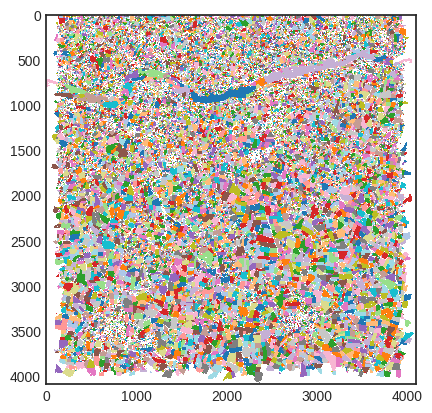

In [ ]:
draw_segmentation(watershed_imgs["72_72614"])
pass